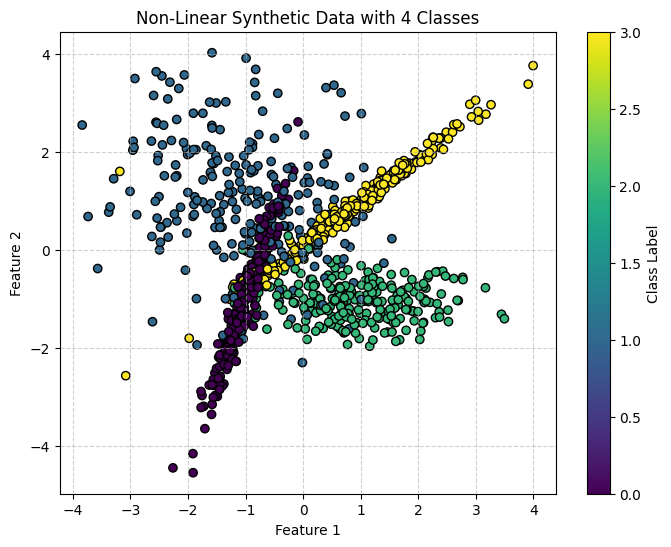

In [281]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=1000, 
    n_features=2, 
    n_redundant=0, 
    n_informative=2, 
    n_clusters_per_class=1, 
    n_classes=4,
    random_state=42
)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, marker='o', edgecolors='k', cmap='viridis')

plt.title(f"Non-Linear Synthetic Data with {len(set(y))} Classes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Class Label")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [282]:
from sklearn.model_selection import train_test_split
import numpy as np

X = np.array(X)
y = np.eye(4)[y.flatten()]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y)

In [283]:
class Layer:
    def __init__(self,no_inputs,no_neuron,activation="relu"):
        if activation == "relu":
            self.weights = np.random.randn(no_inputs, no_neuron) * np.sqrt(2. / no_inputs)
        elif activation == "softmax":
            self.weights = np.random.randn(no_inputs, no_neuron) * np.sqrt(1. / no_inputs)

        self.bias = np.zeros((1, no_neuron))
    def forward(self,X):
        self.inputs = X
        output = np.dot(X,self.weights)+self.bias
        return output
    def backward(self,dvals):
        self.dweights = np.dot(self.inputs.T,dvals)
        self.dbias = np.sum(dvals,axis=0,keepdims=True)
        return np.dot(dvals,self.weights.T)    

class Relu:
    def forward(self,X):
        self.input = X
        return  np.maximum(X,0)
    def backward(self,dvals):
        dvals = dvals.copy()
        dvals[self.input <= 0] = 0
        return dvals

class Softmax:
    def forward(self,X):
        # normalizing
        X_EXP = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.output = X_EXP/np.sum(X_EXP,axis=1,keepdims=True)
        return self.output
    # computationally inefficient better to do dL/dz
    def backward(self,dvals):
        dinputs = np.zeros_like(dvals)
        
        for i,(single_output,single_dvals) in enumerate(zip(self.output,dvals)):
            single_output = single_output.reshape(-1,1)
            
            jacobian = np.diagflat(single_output) - np.dot(single_output,single_output.T)
            dinputs[i] = np.dot(jacobian,single_dvals)
        return dinputs
    # def backward(self,dvals):
    #     return dvals
    
class Loss:
    def loss(self,true,pred):
        pred = np.clip(pred, 1e-7, 1 - 1e-7)
        return -np.mean(np.sum(true*np.log(pred),axis=1))
    def backward(self,true,pred):
        pred = np.clip(pred, 1e-7, 1 - 1e-7)
        # output = (pred - true)/true.shape[0]
        output = -(true/pred)/true.shape[0]
        return output
            

In [284]:
class LearningRateDecay:
    def __init__(self,lr,decay=1e-3 ):
        self._learning_rate = lr
        self.decay = decay
        self.iteration = 0
    @property    
    def learning_rate(self):
        self.iteration+=1
        return self._learning_rate/(1+self.decay*self.iteration)

class Momentum:
    def __init__(self,momentum_factor):
        self.momentum_factor = momentum_factor
    
    def update_weights(self,layers,lr):
        for [layer,_] in layers:
            if not hasattr(layer, 'weight_momentum'):
                layer.weight_momentum = np.zeros_like(layer.weights)
                layer.bias_momentum = np.zeros_like(layer.bias)
            
            layer.weight_momentum = self.momentum_factor*layer.weight_momentum-lr*layer.dweights
            layer.bias_momentum = self.momentum_factor*layer.bias_momentum-lr*layer.dbias
            
            layer.weights += layer.weight_momentum
            layer.bias += layer.bias_momentum

In [285]:
class NeuralNetworkClassifier:
    def __init__(self,no_inputs,no_class,layers,lr=0.01):
        current_input_size = no_inputs
        self.lr = lr
        self.layers = []
        self.loss = Loss()
        self.LRD = LearningRateDecay(self.lr)
        self.optimizer = Momentum(0.9)
        
        for i in layers:
            layer = Layer(current_input_size,i)
            activation = Relu()
            
            self.layers.append([layer,activation])
            current_input_size = i
        
        output_layer = Layer(current_input_size,no_class,'softmax')
        output_activation = Softmax()
        
        self.layers.append([output_layer,output_activation])
    
    def forward(self,X):
        current_output = X
        for [layer,activation] in self.layers:
            current_output = activation.forward(layer.forward(current_output))
        return current_output
    
    def backward(self,X,y):
        output = self.forward(X)
        dvals = self.loss.backward(y,output)
        for [layer,activation] in reversed(self.layers):
            dvals = layer.backward(activation.backward(dvals))
    
    def backpropagation(self,X,y,epoch):
        for i in range(epoch):
            current_lr = self.LRD.learning_rate
            self.backward(X,y)
            self.optimizer.update_weights(self.layers,current_lr)

In [286]:
model = NeuralNetworkClassifier(2,4,[5,7])
model.backpropagation(X_train,y_train,1000)

In [287]:
y_test = np.argmax(y_test,axis=1)
prediction = np.argmax(model.forward(X_test),axis=1)

In [288]:
from sklearn.metrics import accuracy_score

print(f'Accuracy : {accuracy_score(y_test,prediction)}')

Accuracy : 0.8733333333333333


In [289]:
def plot_decision_boundary(model, X, y, step=0.02):
    # 1. Define grid range
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, step),
        np.arange(y_min, y_max, step)
    )

    # 2. Prepare grid input
    grid = np.c_[xx.ravel(), yy.ravel()]

    # 3. Forward pass (no backward, no training)
    probs = model.forward(grid)

    # 4. Predicted class
    Z = np.argmax(probs, axis=1)
    Z = Z.reshape(xx.shape)

    # 5. Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.35, cmap='tab10')

    plt.scatter(
        X[:, 0], X[:, 1],
        c=np.argmax(y, axis=1),
        cmap='tab10',
        edgecolors='k',
        s=30
    )

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.show()


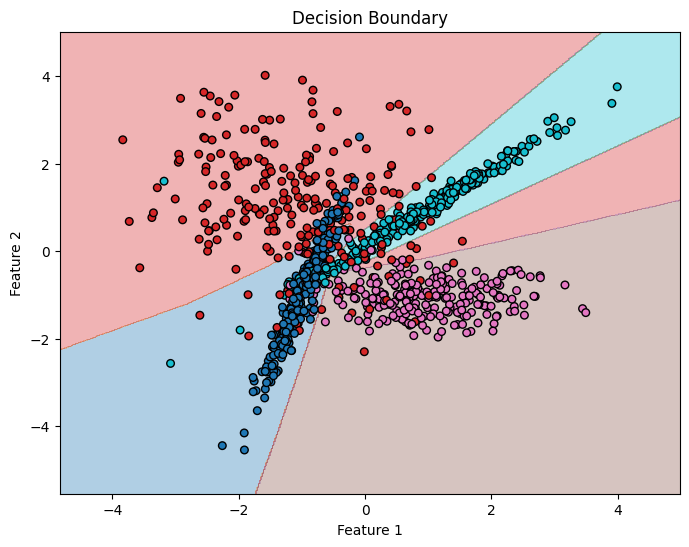

In [290]:
plot_decision_boundary(model, X, y)